# Multiple Body Orbits

Caleb Richards: 4/24/2019

In [112]:
#import needed libraries and classes for use in the project

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook
from matplotlib import animation, rc
from IPython.display import HTML
# Change the common font size
font_size = 10
plt.rcParams.update({'font.size': font_size})

# Orbit Class

In this class, we embed the equations of motion in terms of the cartesian configuration coordinates of the system, namely two ordered (x,y) pairs. To derive the equations of motion, we will start from Newton's law of Gravitation, $\vec{F}-\frac{Gm_{1}m_{2}}{r^{2}} $. This means the potential energy of the system only depends on the distance r between the bodies and is $U(r) = -\frac{Gm_{1}m_{2}}{r^{2}} $. The kinetic energy is then $\frac{1}{2}m_{1}(\dot{x_{1}}^{2} + \dot{y_{1}}^{2})+\frac{1}{2}m_{2}(\dot{x_{2}}^{2} + \dot{y_{2}}^{2})$, which means we can write down the system lagrangian as:

$\begin{align}
\mathcal{L} = T - U = \frac{1}{2}m_{1}(\dot{x_{1}}^{2} + \dot{y_{1}}^{2})+\frac{1}{2}m_{2}(\dot{x_{2}}^{2} + \dot{y_{2}}^{2}) + \frac{Gm_{1}m_{2}}{\sqrt{(x_{2}-      x_{1})^{2} + (y_{2}-y_{1})^{2}}} 
\end{align}$

Applying the Euler-Lagrange Equations to each configuration coordinate, we obtain the equations of motion as the following:

$\begin{align}
 m_{1}\ddot{x_{1}} = \frac{Gm_{1}m_{2}(x_{2}-x_{1})}{[(x_{2}-      x_{1})^{2} + (y_{2}-y_{1})^{2}]^{\frac{3}{2}}}\\
 m_{1}\ddot{y_{1}} = \frac{Gm_{1}m_{2}(y_{2}-y_{1})}{[(x_{2}-      x_{1})^{2} + (y_{2}-y_{1})^{2}]^{\frac{3}{2}}}\\
    m_{1}\ddot{x_{2}} = -\frac{Gm_{1}m_{2}(x_{2}-x_{1})}{[(x_{2}-      x_{1})^{2} + (y_{2}-y_{1})^{2}]^{\frac{3}{2}}}\\
    m_{1}\ddot{y_{2}} = -\frac{Gm_{1}m_{2}(y_{2}-y_{1})}{[(x_{2}-      x_{1})^{2} + (y_{2}-y_{1})^{2}]^{\frac{3}{2}}}\;
\end{align}$

In [144]:
class super_cool_ultra_fancy_two_body_orbit:
    """
    Potentials and associated differential equations for central force motion
    with the potential U(r) = k r^n.  Several algorithms for integration of 
    ordinary differential equations are embedded inside of this. 
    """
    
    def __init__(self, n, k=1, m1=1, m2 = 1):
        
        self.n = n
        self.k = k
        self.m1 = m1
        self.m2 = m2
    
    def U(self, r):
        """Potential energy of the form U = kr^n."""
        return self.k * r**self.n
    
    def Ucf(self, r):
        """Centrifugal potential energy"""
        return self.ang_mom**2 / (2. * self.mu * r**2)
    
    def Ueff(self, r):
        """Effective potential energy"""
        return self.U(r) + self.Ucf(r)
    
    def U_deriv(self, r):
        """dU/dr"""
        return self.n * self.k * r**(self.n - 1)
        
    def Ucf_deriv(self, r):
        """dU_cf/dr"""
        return -2. * self.ang_mom**2 / (2. * self.mu * r**3)
        
    def Ueff_deriv(self, r):
        """dU_eff/dr"""
        return self.U_deriv(r) + self.Ucf_deriv(r)
        
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dr/dt d^2r/dt^2 dphi/dt]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            8-component vector with y[0] = x1(t), y[1] = dx1/dt, y[2] = y1(t), y[3]=dy1/ft
            y[4] = x2(t), y[5] = dx2/dt, y[6] = y2(t), y[7]=dy2/ft
            
        """
        deltax = y[4]-y[0]
        deltay = y[6]-y[2]
        r = (deltax**2 + deltay**2)**(1/2)
        return [ y[1], 
                -(self.k/self.m1)*deltax/r**3, 
                y[3],
                -(self.k/self.m1)*deltay/r**3, 
                y[5],
                (self.k/self.m2)*deltax/r**3,
                y[7],
                (self.k/self.m2)*deltay/r**3
               ]
    
    
    def solve_ode(self, t_pts, x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0,y2_0, y2_dot_0,
                  method='RK23',
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0,y2_0, y2_dot_0]  
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot,y2, y2_dot = solution.y
        return x1, x1_dot, y1, y1_dot, x2, x2_dot,y2, y2_dot
    
    def solve_ode_Euler(self, t_pts, x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0,y2_0, y2_dot_0):
        """
        Solve the ODE given initial conditions with the Euler method.
        The accuracy is determined by the spacing of times in t_pts.
        """
        
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, phi with zeros
        num_t_pts = len(t_pts)    # length of the array t_pts
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        x2 = np.zeros(num_t_pts)
        x2_dot= np.zeros(num_t_pts)
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        
        
        # initial conditions
        x1[0] = x1_0
        x1_dot[0] = x1_dot_0
        y1[0] = y1_0
        y1_dot[0] = y1_dot_0
        x2[0] = x2_0
        x2_dot[0] = x2_dot_0
        y2[0] = y2_dot_0
        y2_dot[0] = y2_dot_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            
            x1[i+1] = x1[i]+self.dy_dt(t,y)[0]*delta_t
            x1_dot[i+1] = x1_dot[i]+self.dy_dt(t,y)[1]*delta_t
            y1[i+1] = y1[i]+self.dy_dt(t,y)[2]*delta_t
            y1_dot[i+1] = y1_dot[i]+self.dy_dt(t,y)[3]*delta_t
            x2[i+1] = x2[i]+self.dy_dt(t,y)[4]*delta_t
            x2_dot[i+1] = x2_dot[i]+self.dy_dt(t,y)[5]*delta_t
            y2[i+1] = y2[i]+self.dy_dt(t,y)[6]*delta_t
            y2_dot[i+1] = y2_dot[i]+self.dy_dt(t,y)[7]*delta_t
            
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot,y2, y2_dot
    
    
    def solve_ode_Leapfrog(self, t_pts, x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0,y2_0, y2_dot_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_h = np.zeros(num_t_pts)
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_h = np.zeros(num_t_pts)
        x2 = np.zeros(num_t_pts)
        x2_dot= np.zeros(num_t_pts)
        x2_dot_h = np.zeros(num_t_pts)
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_h = np.zeros(num_t_pts)
        
        
        # initial conditions
        x1[0] = x1_0
        x1_dot[0] = x1_dot_0
        y1[0] = y1_0
        y1_dot[0] = y1_dot_0
        x2[0] = x2_0
        x2_dot[0] = x2_dot_0
        y2[0] = y2_dot_0
        y2_dot[0] = y2_dot_0
        
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            y = [x1[i], x1_dot[i], y1[i],y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            x1_dot_h[i] = x1_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            y1_dot_h[i] = y1_dot[i] + self.dy_dt(t, y)[3] * delta_t/2.
            x2_dot_h[i] = x2_dot[i] + self.dy_dt(t, y)[5] * delta_t/2.
            y2_dot_h[i] = y2_dot[i] + self.dy_dt(t, y)[7] * delta_t/2.
            
            x1[i+1] = x1[i] + x1_dot_h[i]*delta_t
            y1[i+1] = y1[i] + y1_dot_h[i]*delta_t
            x2[i+1] = x2[i] + x2_dot_h[i]*delta_t
            y2[i+1] = y2[i] + y2_dot_h[i]*delta_t
            
            #y = [r[i], r_dot[i], phi[i]]
            #r_dot_half[i] = r_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            #r[i+1] = r[i] + r_dot_half[i] * delta_t
            
            y = [x1[i+1], x1_dot[i], y1[i+1],y1_dot[i], x2[i+1], x2_dot[i], y2[i+1], y2_dot[i]]
            #y = [r[i+1], r_dot[i], phi[i]]
            x1_dot[i+1] = x1_dot_h[i] + self.dy_dt(t, y)[1] * delta_t/2.
            y1_dot[i+1] = y1_dot_h[i] + self.dy_dt(t, y)[3] * delta_t/2.
            x2_dot[i+1] = x2_dot_h[i] + self.dy_dt(t, y)[5] * delta_t/2.
            y2_dot[i+1] = y2_dot_h[i] + self.dy_dt(t, y)[7] * delta_t/2.
            #r_dot[i+1] = r_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot,y2, y2_dot  
        
    
    def energy(self, t_pts, r, r_dot):
        """Evaluate the energy as a function of time"""
        return (self.mu/2.) * r_dot**2 + self.Ueff(r)

In [145]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [146]:
#returns the indices of a specified value in the array
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Analysis

We will solve the equations using some of the methods we have developed above for this, and compare the results for a 2-body orbit with two equal mass bodies. In particular, we will investigate the accuracy of the solvers by plotting the time evolution of the energy using each. Then, we will investigate an orbit where one mass is much heavier than the other and look at what happens with that situation.


(<matplotlib.axes._subplots.AxesSubplot at 0x20a5428cc50>,
 <matplotlib.lines.Line2D at 0x20a50e86f60>)

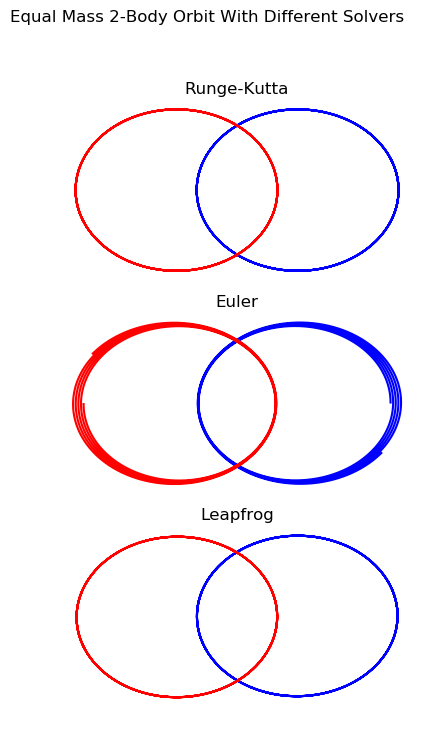

In [182]:
m1 = 1
m2 = 1
n = -1. #for gravity
k = -1. #to make it an attractive force

#change these ICs for various effects
x1_0 = 10
x1_dot_0 = 0
y1_0 = 0
y1_dot_0 = 0.1


#don't change these: designed to keep CM in a fixed place!!
x2_0 = -x1_0
x2_dot_0 = -m1/m2*x1_dot_0
y2_0 = -y1_0
y2_dot_0 = -m1/m2*y1_dot_0



t_start = 0.
t_end = 1000.
t_pts = np.linspace(t_start, t_end, 100000)


O2 = super_cool_ultra_fancy_two_body_orbit(n=n,k=k, m1=m1,m2=m2)
#use defualt solve ivp problem
x1, x1_dot, y1, y1_dot, x2, x2_dot,y2, y2_dot = O2.solve_ode(x1_0 = x1_0, 
                                                             x1_dot_0 =x1_dot_0, y1_0=y1_0, y1_dot_0=y1_dot_0, 
                                                             x2_0=x2_0, x2_dot_0=x2_dot_0,y2_0=y2_0, 
                                                             y2_dot_0=y2_dot_0, t_pts = t_pts)


#use Euler Method
x1_Euler, x1_dot_Euler, y1_Euler, y1_dot_Euler, x2_Euler, x2_dot_Euler,y2_Euler, y2_dot_Euler = O2.solve_ode_Euler(
                                                             x1_0 = x1_0, x1_dot_0 =x1_dot_0, y1_0=y1_0, 
                                                             y1_dot_0=y1_dot_0, x2_0=x2_0, x2_dot_0=x2_dot_0,
                                                             y2_0=y2_0, y2_dot_0=y2_dot_0, t_pts = t_pts)

#use Leapfrog Method
x1_Leapfrog, x1_dot_Leapfrog, y1_Leapfrog, y1_dot_Leapfrog, x2_Leapfrog, x2_dot_Leapfrog,y2_Leapfrog, y2_dot_Leapfrog = O2.solve_ode_Leapfrog(x1_0 = x1_0, 
                                        x1_dot_0 =x1_dot_0, y1_0=y1_0, y1_dot_0=y1_dot_0, 
                                        x2_0=x2_0, x2_dot_0=x2_dot_0,y2_0=y2_0, 
                                        y2_dot_0=y2_dot_0, t_pts = t_pts)


#plot
fig = plt.figure(figsize = (24,8))
fig.suptitle('Equal Mass 2-Body Orbit With Different Solvers', va='baseline')
ax.set_aspect = 'equal'
ax = fig.add_subplot(3,1,1)
ax.set_axis_off()
ax.set_aspect('equal')
plot_y_vs_x(x1,y1,ax=ax, color = 'blue', title = r'Runge-Kutta')
plot_y_vs_x(x2,y2,ax=ax, color = 'red')
ax2 = fig.add_subplot(3,1,2)
ax2.set_aspect('equal')
ax2.set_axis_off()
plot_y_vs_x(x1_Euler,y1_Euler,ax=ax2, color = 'blue', title = r'Euler')
plot_y_vs_x(x2_Euler,y2_Euler,ax=ax2, color = 'red')
ax3 = fig.add_subplot(3,1,3)
ax3.set_axis_off()
ax3.set_aspect('equal')
plot_y_vs_x(x1_Leapfrog,y1_Leapfrog,ax=ax3, color = 'blue', title = r'Leapfrog')
plot_y_vs_x(x2_Leapfrog,y2_Leapfrog,ax=ax3, color = 'red')


[0.00000000e+00 1.73472348e-16 1.30104261e-14 ... 3.37681475e-08
 3.37684077e-08 3.37684890e-08]


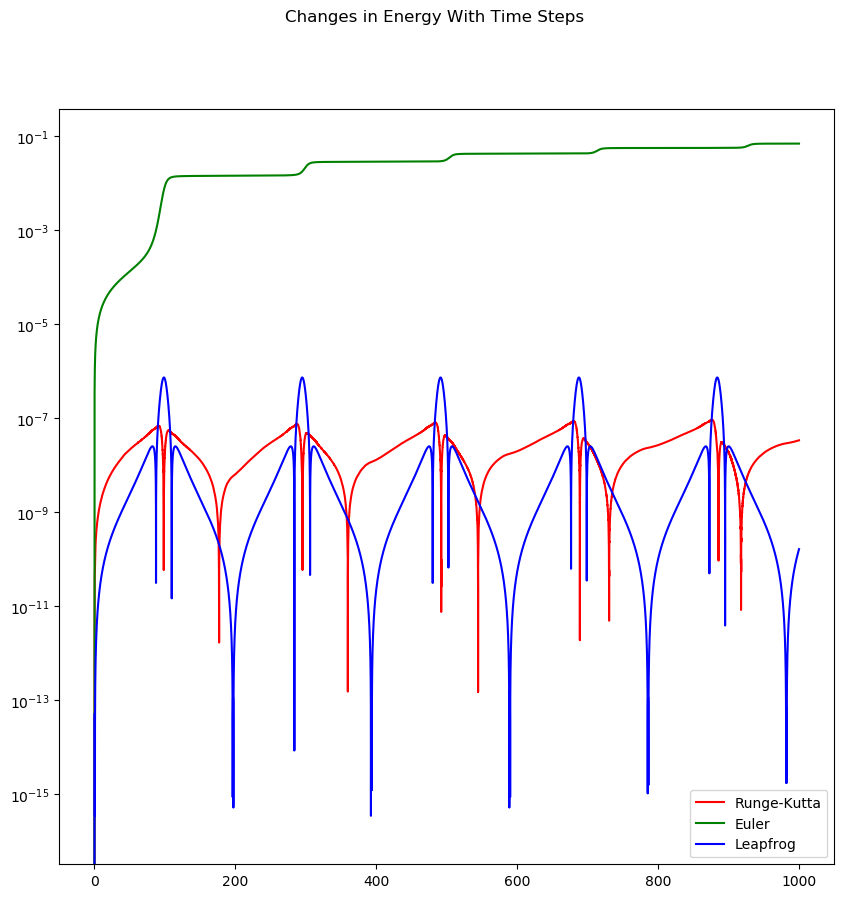

In [183]:
#Now we want to see how the energy changes as time goes on

#runge-kutta
r = np.sqrt((x2-x1)**2 + (y2-y1)**2)
U = k*r**n
T = 1/2*m1*(x1_dot**2 + y1_dot**2) + 1/2*m2*(x2_dot**2 + y2_dot**2)
E = T+U
E0 = E[0]
Erel = np.abs((E-E0)/E0)

#euler
r_e = np.sqrt((x2_Euler-x1_Euler)**2 + (y2_Euler-y1_Euler)**2)
U_e = k*r_e**n
T_e = 1/2*m1*(x1_dot_Euler**2 + y1_dot_Euler**2) + 1/2*m2*(x2_dot_Euler**2 + y2_dot_Euler**2)
E_e = U_e + T_e
E_e0 = E_e[0]
E_erel = np.abs((E_e - E_e0)/E_e0)

#leapfrog
r_l = np.sqrt((x2_Leapfrog-x1_Leapfrog)**2 + (y2_Leapfrog-y1_Leapfrog)**2)
U_l = k*r_l**n
T_l = 1/2*m1*(x1_dot_Leapfrog**2 + y1_dot_Leapfrog**2) + 1/2*m2*(x2_dot_Leapfrog**2 + y2_dot_Leapfrog**2)
E_l =  U_l + T_l
E_l0 = E_l[0]
E_lrel = np.abs((E_l - E_l0)/E_l0)

fig2 = plt.figure(figsize=(10,10))
fig2.suptitle('Changes in Energy With Time Steps')
axE = fig2.add_subplot(1,1,1)
plot_y_vs_x(t_pts, Erel,  color = 'red', semilogy = 'true',label = r'Runge-Kutta')
plot_y_vs_x(t_pts, E_erel,  color = 'green', semilogy = 'true',label = r'Euler')
plot_y_vs_x(t_pts, E_lrel,  color = 'blue', semilogy = 'true',label = r'Leapfrog')

print(Erel)

# Limiting Case of Heavy Mass

Looking at the above, we see that the Euler method is terrible as the energy error grows exponetially. Looking at the orbit plot, we can even see the orbit drifting. The leapfrog method conserves energy as it was designed to, since the percent error is bounded (at least in the time considered here). The runge-kutta method also conserves energy for this scenario since its error is bounded as well, even though it was not explicitly designed to.

Now to further look at things, we will rerun letting the mass 2 become very heavy compared to m1, and thus expect to behave as if it is bolted down at its initial position, and the other mass to orbit in ellipse with the heavy mass as a focus

(<matplotlib.axes._subplots.AxesSubplot at 0x20a5bc98f98>,
 <matplotlib.lines.Line2D at 0x20a5cdd1a90>)

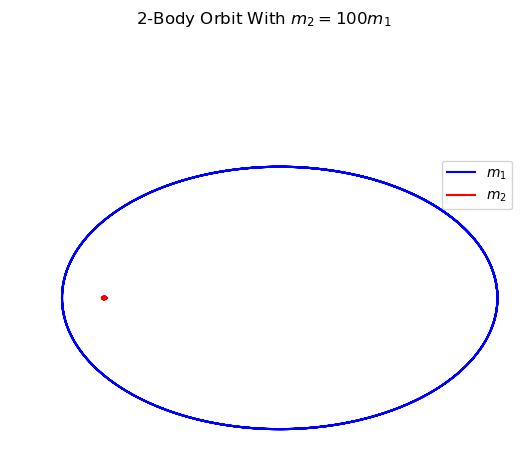

In [186]:
m2 = 100*m1

#change these ICs for various effects
x1_0 = 10
x1_dot_0 = 0
y1_0 = 0
y1_dot_0 = 0.1


#don't change these: designed to keep CM in a fixed place!!
x2_0 = -x1_0
x2_dot_0 = -m1/m2*x1_dot_0
y2_0 = -y1_0
y2_dot_0 = -m1/m2*y1_dot_0


#create our orbit class
O2h = super_cool_ultra_fancy_two_body_orbit(n=n,k=k, m1=m1,m2=m2)
#use defualt solve ivp problem because why not? At least its not the Euler method!
x1h, x1_doth, y1h, y1_doth, x2h, x2_doth,y2h, y2_doth = O2h.solve_ode(x1_0 = x1_0, 
                                                             x1_dot_0 =x1_dot_0, y1_0=y1_0, y1_dot_0=y1_dot_0, 
                                                             x2_0=x2_0, x2_dot_0=x2_dot_0,y2_0=y2_0, 
                                                             y2_dot_0=y2_dot_0, t_pts = t_pts)

#plot
fig3 = plt.figure(figsize = (13,13))
fig3.suptitle(r'2-Body Orbit With $m_2 = 100m_1$', va='baseline')
axh = fig3.add_subplot(3,1,1)
axh.set_axis_off()
axh.set_aspect('equal')
plot_y_vs_x(x1h,y1h,ax=axh, color = 'blue', label = r'$m_1$')
plot_y_vs_x(x2h,y2h,ax=axh, color = 'red',label = r'$m_2$')

# Animation! 

We will use the results from the equal mass situation with the runge-kutta method to generate

In [240]:
%%capture

fig_anim = plt.figure(figsize=(7,7), num='Double Orbit Animation')
ax_anim = fig_anim.add_subplot(1,1,1)
xmin = -20
xmax = 20
ymin = -20
ymax = 20
r1 = 0.7
r2 = 0.7
ax_anim.set_xlim(xmin, xmax)
ax_anim.set_ylim(ymin, ymax)
ax_anim.set_aspect('equal')
ax_anim.set_axis_off()

line_anim1, = ax_anim.plot(x1,y1, lw=2, color = 'b')
line_anim2, = ax_anim.plot(x2,y2, lw=2, color = 'r')

bob1 = plt.Circle((0,0), radius = r1, fc = 'k')
bob2 = plt.Circle((0,0), radius = r2, fc = 'k')
ax_anim.add_patch(bob1)
ax_anim.add_patch(bob2)
fig_anim.tight_layout()

#limit to twenty by truncating and slicing the array of time points
start, stop = start_stop_indices(t_pts, t_start, t_start+250)
new_t_pts = t_pts[start : stop : 100]
new_x1 = x1[start : stop : 100]
new_y1 = y1[start : stop : 100]
new_x2 = x2[start : stop : 100]
new_y2 = y2[start : stop : 100]

In [241]:
def animate_orbit(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    t = new_t_pts[i]
    
    center1 = [new_x1[i], new_y1[i]]
    center2 = [new_x2[i],new_y2[i]]
    
    bob1.center = (center1)
    bob2.center = (center2)
    #line_anim.set_data(data1, data2)  # overwrite line_anim with new points
    return ( ) # this is needed for blit=True to work



In [244]:
frame_interval = 15.  # time between frames

#limit to twenty seconds by creating truncating the array of time points
start, stop = start_stop_indices(t_pts, t_start, t_start+200)
new_t_pts = t_pts[start : stop : 100]
print(np.size(new_t_pts))
frame_number = np.size(new_t_pts)    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_orbit, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

#fig.show()

200


In [245]:
plt.rcParams['animation.embed_limit']=60
HTML(anim.to_jshtml())